<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#true-positives" data-toc-modified-id="true-positives-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>true positives</a></span></li><li><span><a href="#false-positives" data-toc-modified-id="false-positives-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>false positives</a></span></li><li><span><a href="#false-negatives" data-toc-modified-id="false-negatives-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>false negatives</a></span></li><li><span><a href="#true-positives" data-toc-modified-id="true-positives-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>true positives</a></span></li><li><span><a href="#false-positives" data-toc-modified-id="false-positives-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>false positives</a></span></li><li><span><a href="#false-negatives" data-toc-modified-id="false-negatives-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>false negatives</a></span></li></ul></div>

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from skimage import io, color, transform, feature, exposure, filters, morphology
import my_measures # note, this was updated March 27; make sure you are using the current version! 
%matplotlib inline

In [101]:
# file paths/names

root_dir = '/Users/aucherserr/Desktop/MachineLearning/myGit/ml/mlAssignment2/plane_data/'

ci_path = root_dir + 'cropped_images_18/' # cropped images for training
l_file = root_dir + 'plane_labels_2018.csv' # csv with labels

# get labels and extract features from images

In [102]:
# all labels
plane_data = pd.read_csv(l_file)
print(plane_data.head())
print(plane_data.shape)

                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
(6758, 2)


In [196]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
# dims = (15, 35) # 25% of the original size, 525 pixels
# dims = (18, 42) # 30% of the original size, 525 pixels
dims = (30, 70) # 30% of the original size, 525 pixels

(60, 140)
(60, 140, 4)
(60, 140)
(60, 140, 4)
(60, 140)
(60, 140, 4)


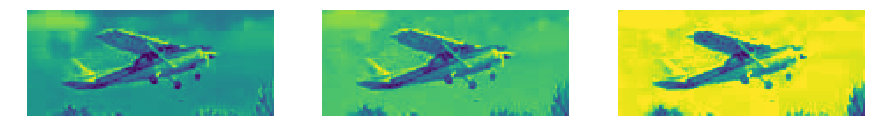

In [104]:
## Playing with Color Channels

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
im = '2016-10-07T17+44+06_330Z'


for c, ax in zip(range(3), axs):
    imname = ci_path + im + '.png'
    img_raw = io.imread(imname)
    tmp_im = np.zeros(img_raw.shape, dtype="uint8")
    tmp_im = img_raw[:,:,c]
    ax.imshow(tmp_im)
    print(tmp_im.shape)
    print(img_raw.shape)
    ax.set_axis_off()


downscaled image shape: 
(30, 70)
image representation (first row of pixels): 
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]


example of transformation: 


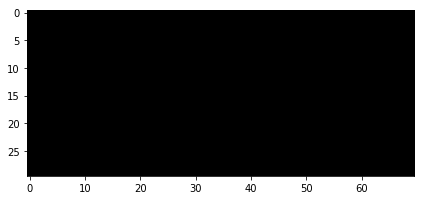

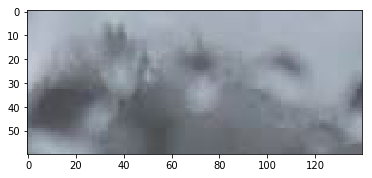

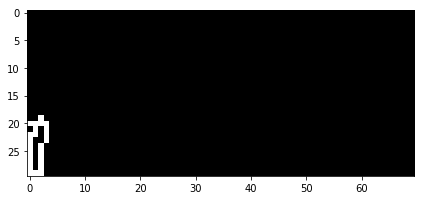

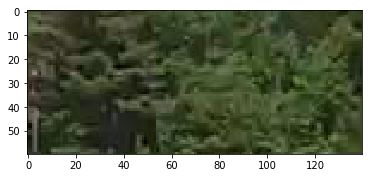

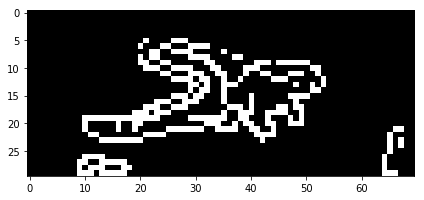

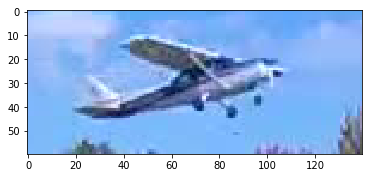

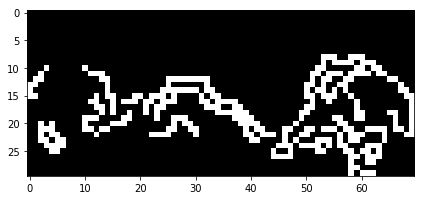

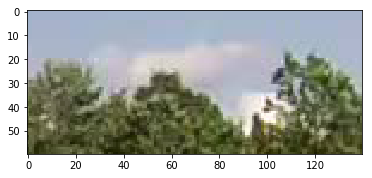

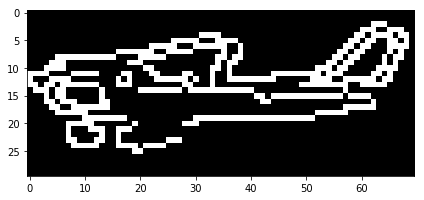

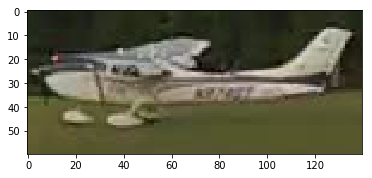

In [197]:
# scikit-image documentation on methods used for feature extraction: 
#    http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray
#    http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
#    http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

def image_manipulation(imname, imview=False):
    warnings.filterwarnings('ignore')
    imname = ci_path + imname + '.png'
    img_raw = io.imread(imname)
    gray = color.rgb2gray(img_raw) # remove color

    ## thresholding on multiple color channels
    c_ims = []
    for c in range(3): #loop through color channels
        tmp_im = img_raw[:,:,c]
        filtered = filters.scharr(tmp_im)
        canny = feature.canny(filtered, sigma = 1.5)  
        downscaled = transform.resize(canny, (dims[0], dims[1]))
        c_ims.append(downscaled.astype(bool))
    
#   add together all the features that all three color channels saw
    final_image1 = c_ims[0] & c_ims[1] & c_ims[2]

    if imview==True:    
        plt.figure()
        io.imshow(final_image1)
        plt.figure()
        plt.imshow(img_raw)
    warnings.filterwarnings('always')
    return final_image1

# test the function, look at input/output
test_image = image_manipulation('2018-01-12T12+51+53_080Z', True)
test_image = image_manipulation('2017-07-09T18+59+02_850Z', True)
test_image = image_manipulation('2016-10-07T17+44+06_330Z', True)
test_image = image_manipulation('2017-08-19T19+34+08_350Z', True)
test_image = image_manipulation('2017-07-16T23+13+31_720Z', True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')


In [211]:
#wrongly tagged negative - filter it out from training
plane_data = plane_data[plane_data.img_name != '2017-09-01T18+57+47_590Z']

In [212]:
# construct lists for features, labels, and a crosswalk reference to image names

features_list = []
y_list = []
imnames_list = []

for index, row in plane_data.iterrows(): 
    features_list.append(image_manipulation(row['img_name']))
    y_list.append(row['plane'])
    imnames_list.append(row['img_name'])
    

In [13]:
print(imnames_list[0])
features_list[0]

2016-08-02T13+50+24_430Z


array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, Fal

In [213]:
# convert the lists to ndarrays
features = np.asarray(features_list)
Y = np.asarray(y_list)
imgs = np.asarray(imnames_list)
print('Shape of original feature representation: ')
print(features.shape)

# flatten the images ndarray to one row per image
features_flat = features.reshape((features.shape[0], -1))

print('Shape of flat feature representation: ')
print(features_flat.shape)

print('Shape of Y: ')
print(Y.shape)

print('Number of images with planes: ')
print(Y.sum())

Shape of original feature representation: 
(6757, 30, 70)
Shape of flat feature representation: 
(6757, 2100)
Shape of Y: 
(6757,)
Number of images with planes: 
101


In [214]:
# create train and test sets
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
    Y, imgs, test_size = 0.25, random_state = 12)

print('Shape of training set: ')
print(y_train.shape)
print('Number of training images that contain an airplane: ')
print(y_train.sum())

print(' ')

print('Shape of test set: ')
print(y_test.shape)
print('Number of test images that contain an airplane: ')
print(y_test.sum())

Shape of training set: 
(5067,)
Number of training images that contain an airplane: 
76
 
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
25


# train Perceptron

In [215]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(data_train, y_train)

prc_performance = my_measures.BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = my_measures.BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


TRAINING SET: 
{'Pos': 76, 'Neg': 4991, 'TP': 74, 'TN': 4987, 'FP': 4, 'FN': 2, 'Accuracy': 0.99881586737714623, 'Precision': 0.94871794871794868, 'Recall': 0.97368421052631582, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 25, 'Neg': 1665, 'TP': 18, 'TN': 1663, 'FP': 2, 'FN': 7, 'Accuracy': 0.9946745562130177, 'Precision': 0.90000000000000002, 'Recall': 0.71999999999999997, 'desc': 'prc', 'set': 'test'}


In [216]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
#         print(imnames_list[img])
        warnings.filterwarnings('ignore')    
        plt.figure()
        print(imgs_test[img])
        plt.title(imgs_test[img])
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')


# look at examples of Perceptron classifications

## true positives

2016-10-16T14+19+27_180Z
2017-07-09T19+11+06_580Z
2016-10-07T17+44+06_330Z
2017-02-04T19+24+55_780Z
2017-07-05T23+05+37_890Z
2017-09-18T19+59+22_050Z
2017-07-16T19+22+59_630Z
2016-08-15T14+26+53_630Z
2017-08-13T16+48+08_080Z
2017-06-28T18+23+15_110Z
2017-02-04T19+28+21_630Z
2016-12-04T14+31+37_880Z
2016-10-19T20+06+45_590Z
2017-07-09T18+27+26_140Z
2017-07-09T15+59+51_510Z
2017-09-12T14+16+42_290Z
2016-10-07T17+52+56_250Z
2017-06-28T18+20+25_840Z


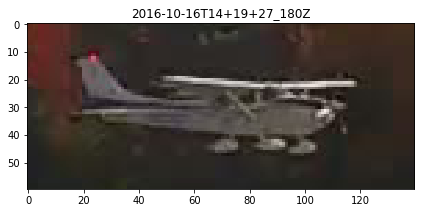

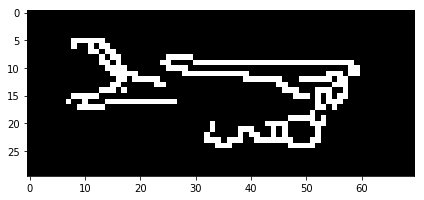

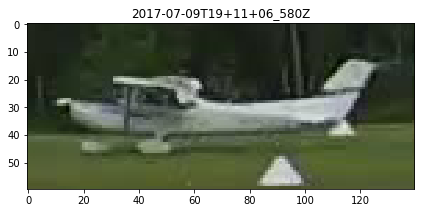

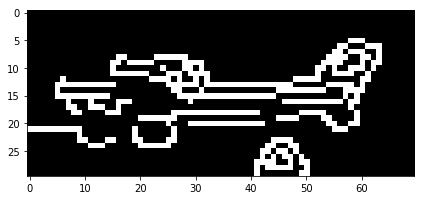

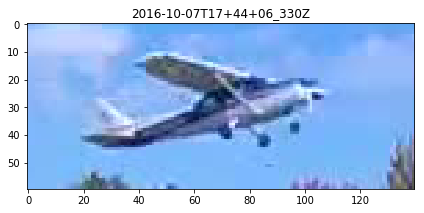

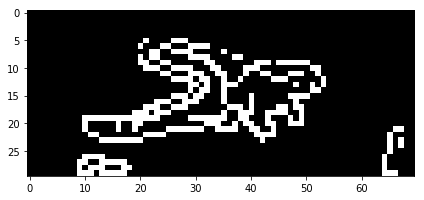

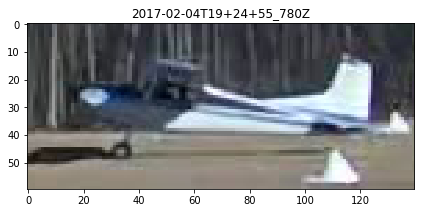

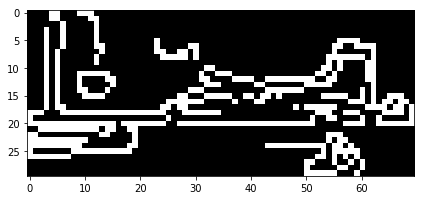

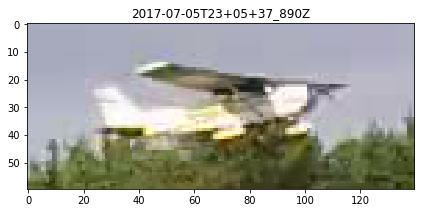

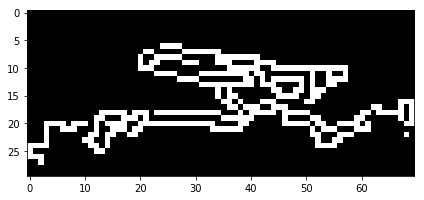

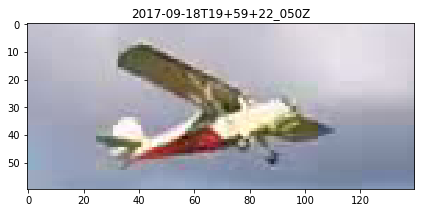

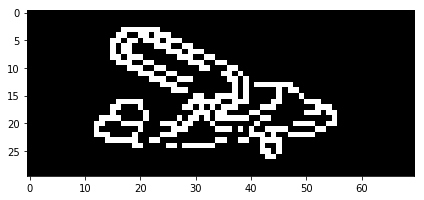

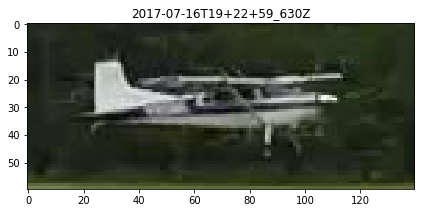

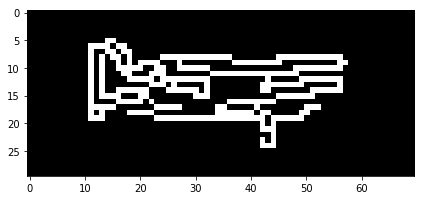

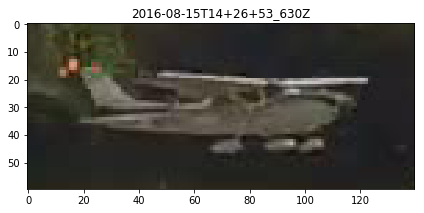

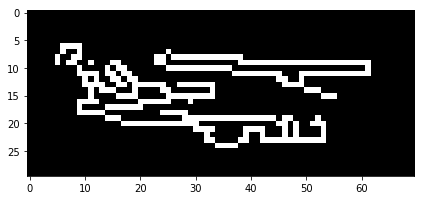

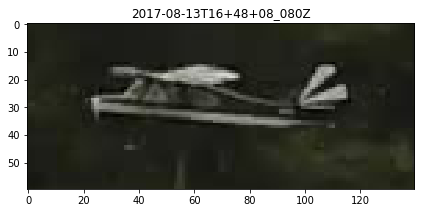

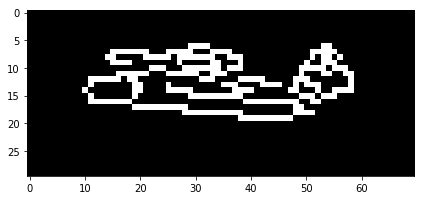

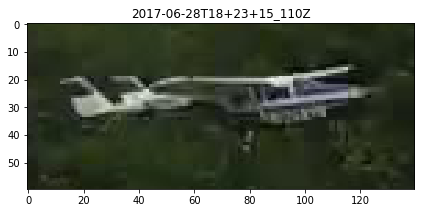

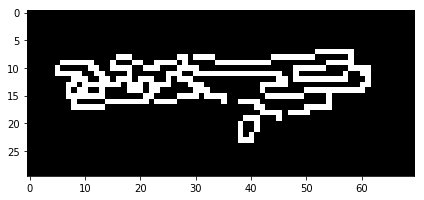

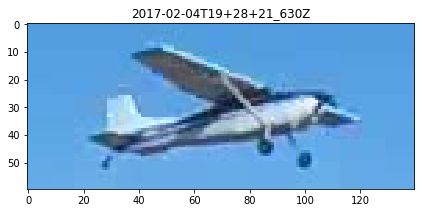

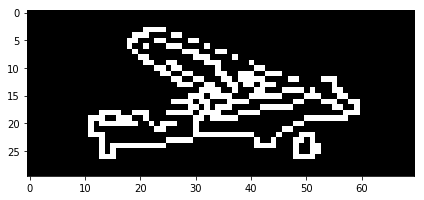

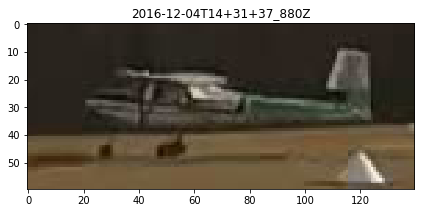

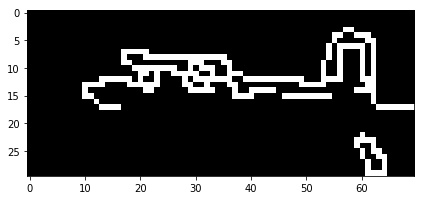

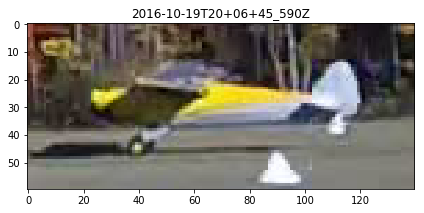

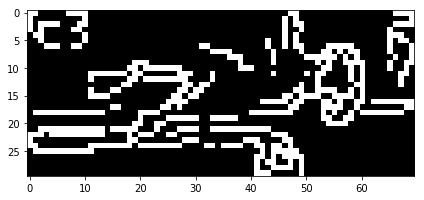

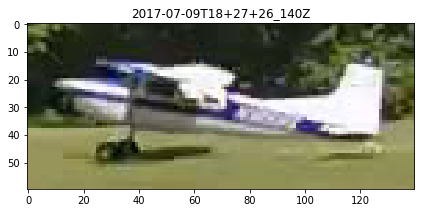

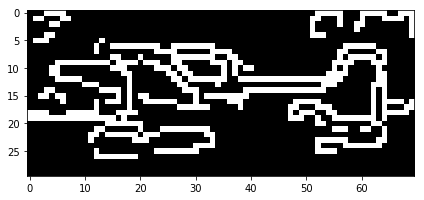

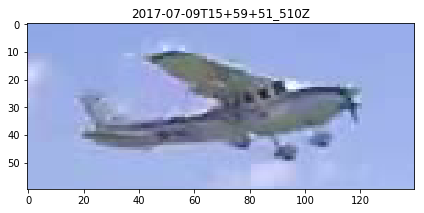

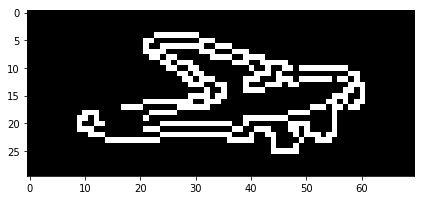

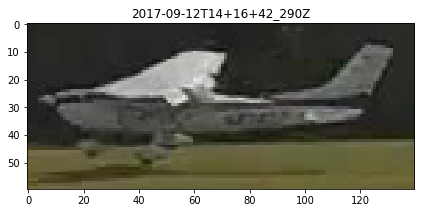

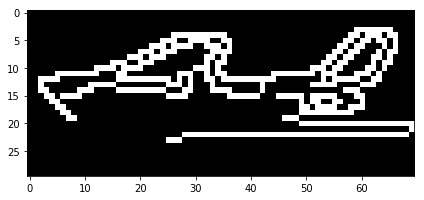

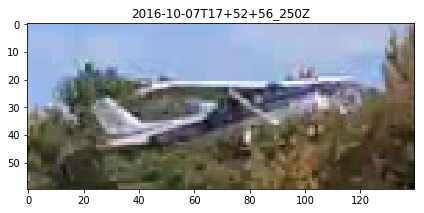

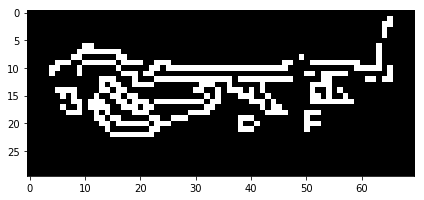

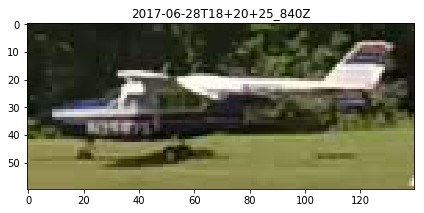

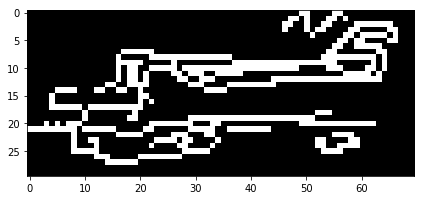

In [217]:
performance_examples('TP', prc_img_indices_to_view)

## false positives

2017-07-24T17+05+27_430Z
2017-08-03T11+29+26_570Z


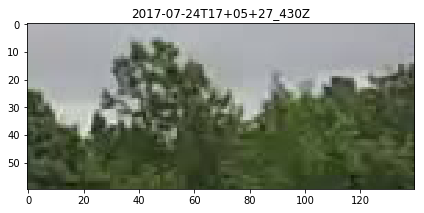

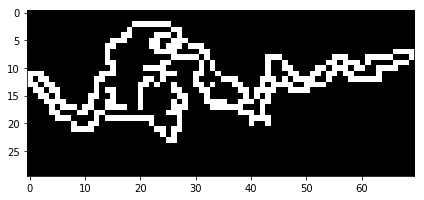

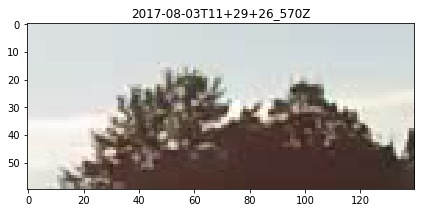

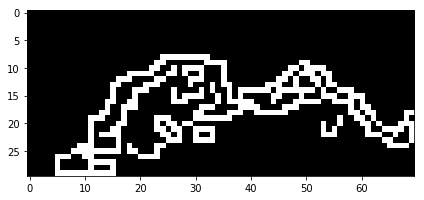

In [218]:
performance_examples('FP', prc_img_indices_to_view)

## false negatives

2017-09-16T18+06+08_080Z
2016-08-28T13+58+11_200Z
2017-07-26T13+21+45_310Z
2017-07-30T19+51+27_270Z
2017-12-01T15+51+08_650Z
2016-11-12T19+05+51_000Z
2017-11-23T12+49+59_380Z


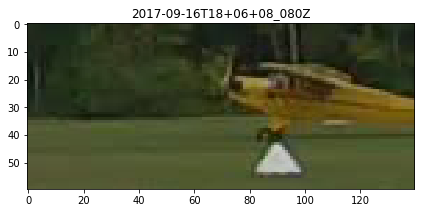

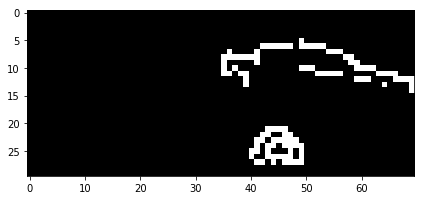

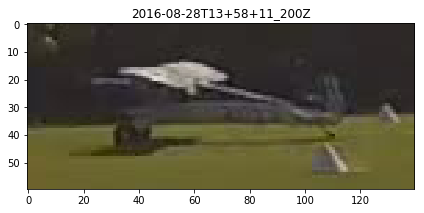

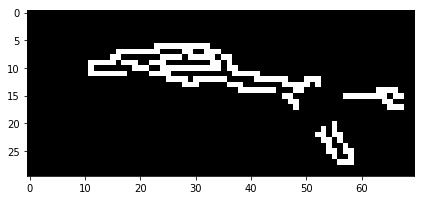

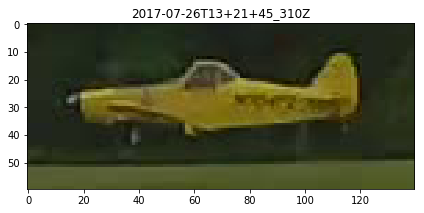

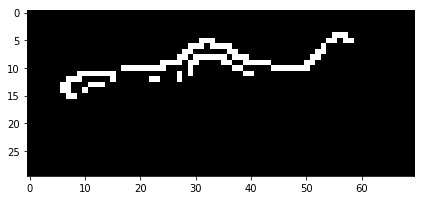

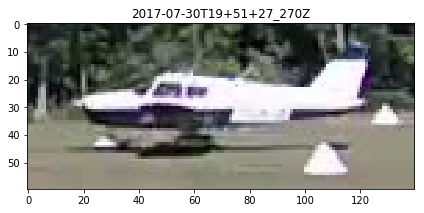

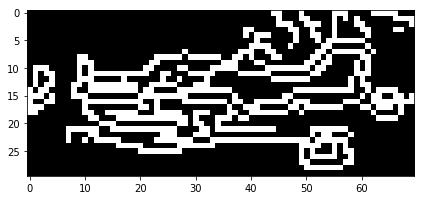

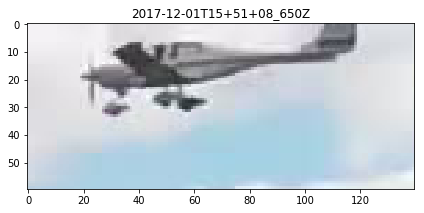

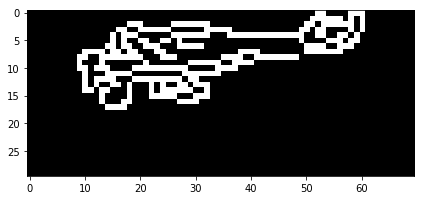

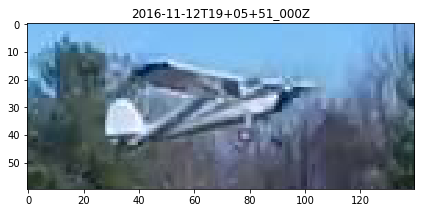

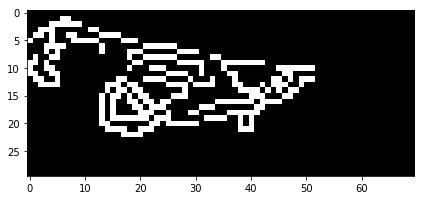

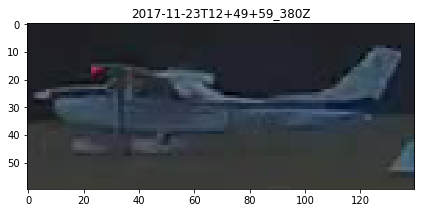

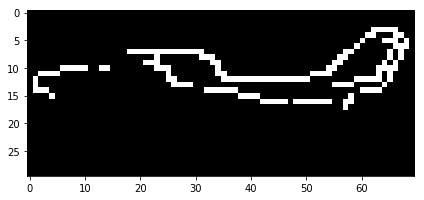

In [219]:
performance_examples('FN', prc_img_indices_to_view)

# train Multilayer Perceptron, a.k.a. neural network

In [236]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(max_iter=1000, alpha = 2)
print(nn)
nn.fit(data_train, y_train)

nn_performance = my_measures.BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = my_measures.BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(activation='relu', alpha=2, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 76, 'Neg': 4991, 'TP': 75, 'TN': 4991, 'FP': 0, 'FN': 1, 'Accuracy': 0.99980264456285772, 'Precision': 1.0, 'Recall': 0.98684210526315785, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 25, 'Neg': 1665, 'TP': 17, 'TN': 1664, 'FP': 1, 'FN': 8, 'Accuracy': 0.9946745562130177, 'Precision': 0.94444444444444442, 'Recall': 0.68000000000000005, 'desc': 'nn_test', 'set': 'test'}


In [241]:
from sklearn.externals import joblib
joblib.dump(nn, 'nn.pkl')

['nn.pkl']

# look at examples of neural network classifications

## true positives

2016-10-16T14+19+27_180Z
2017-07-09T19+11+06_580Z
2016-10-07T17+44+06_330Z
2017-07-05T23+05+37_890Z
2016-08-28T13+58+11_200Z
2017-07-16T19+22+59_630Z
2016-08-15T14+26+53_630Z
2017-08-13T16+48+08_080Z
2017-02-04T19+28+21_630Z
2016-12-04T14+31+37_880Z
2017-07-09T15+59+51_510Z
2017-09-12T14+16+42_290Z
2016-10-07T17+52+56_250Z
2017-06-28T18+20+25_840Z


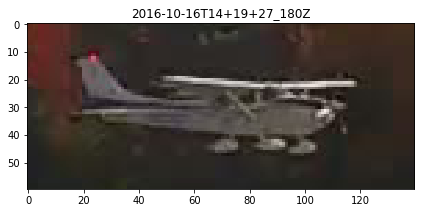

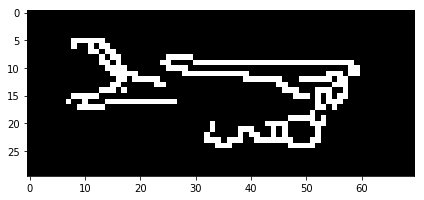

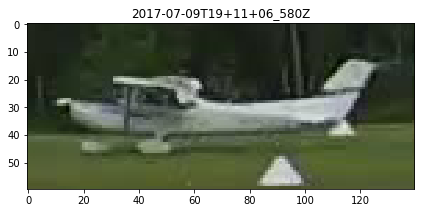

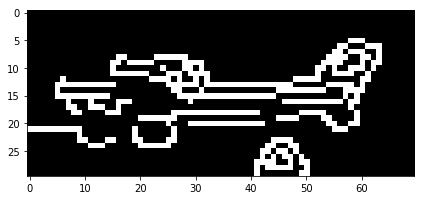

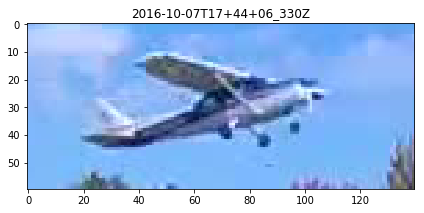

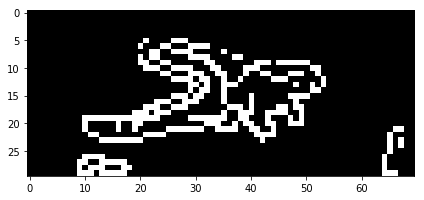

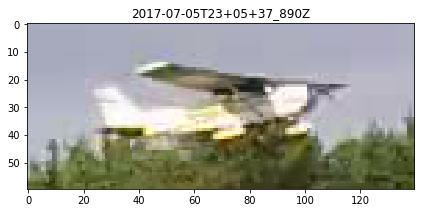

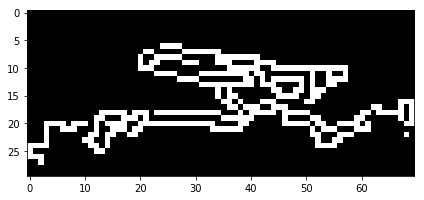

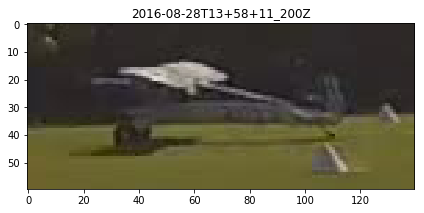

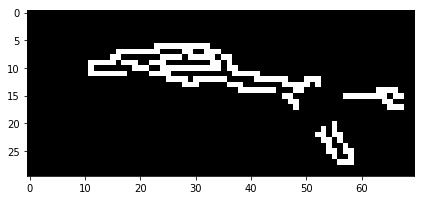

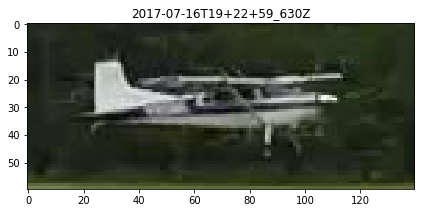

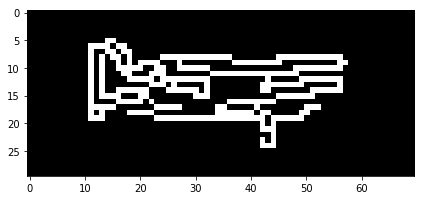

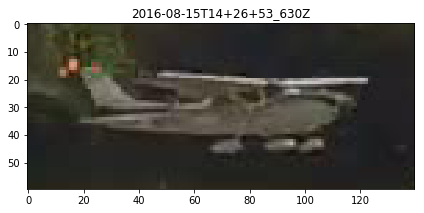

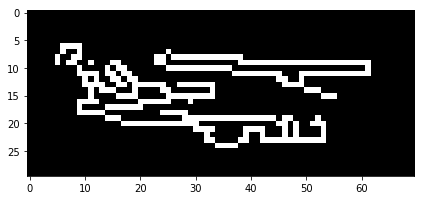

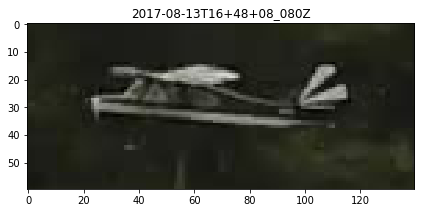

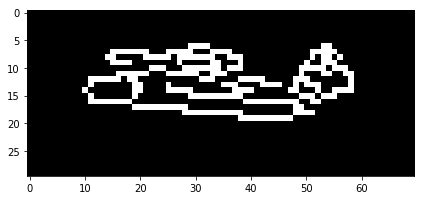

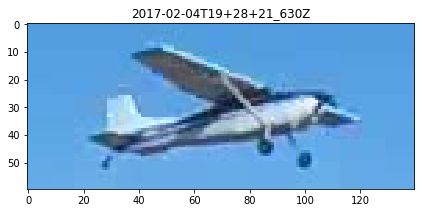

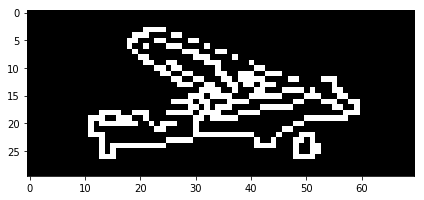

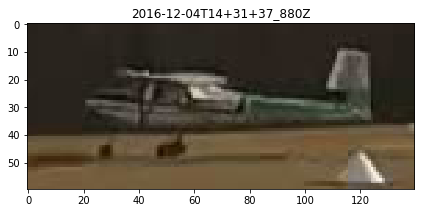

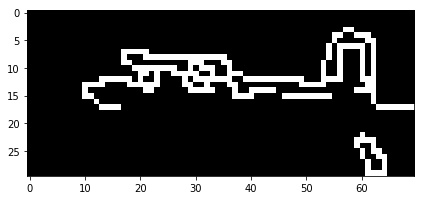

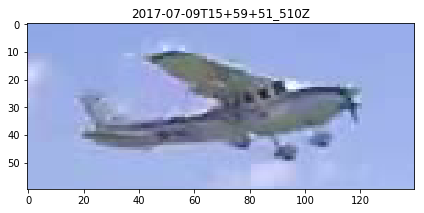

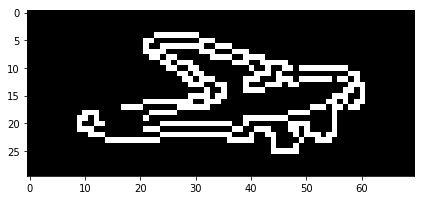

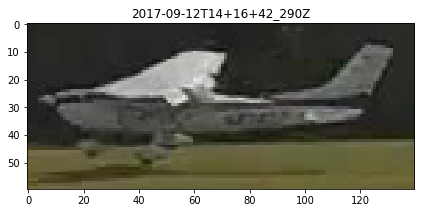

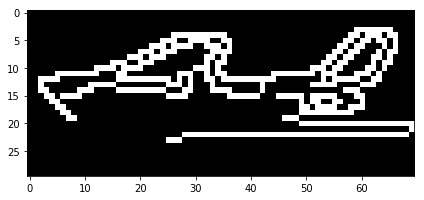

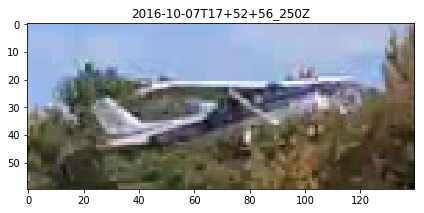

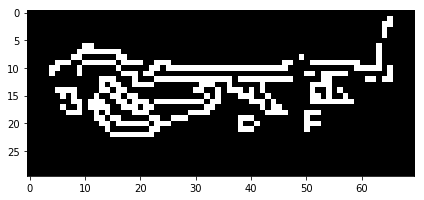

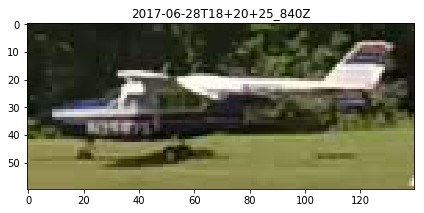

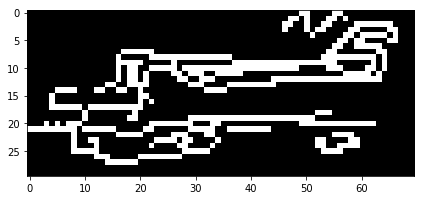

In [226]:
performance_examples('TP', nn_img_indices_to_view)

## false positives

In [227]:
performance_examples('FP', nn_img_indices_to_view)

## false negatives

2017-09-16T18+06+08_080Z
2017-07-26T13+21+45_310Z
2017-07-30T19+51+27_270Z
2017-12-01T15+51+08_650Z
2017-02-04T19+28+21_630Z
2016-11-12T19+05+51_000Z
2016-10-19T20+06+45_590Z
2017-11-23T12+49+59_380Z


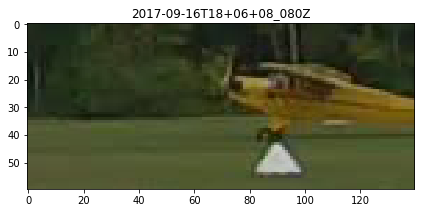

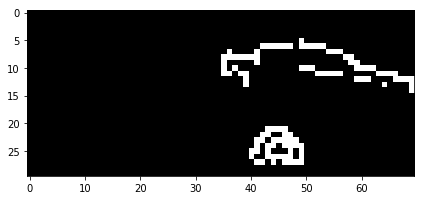

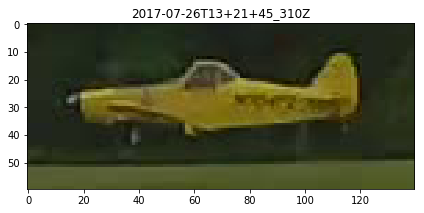

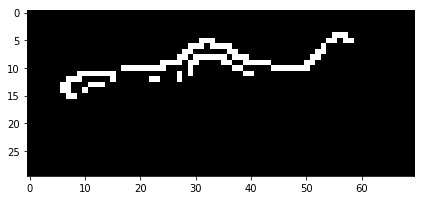

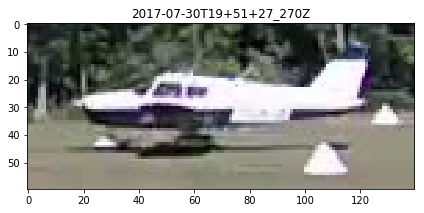

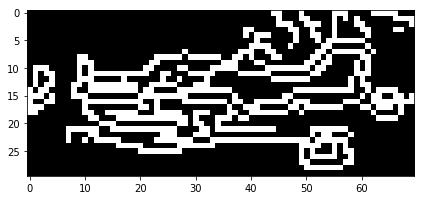

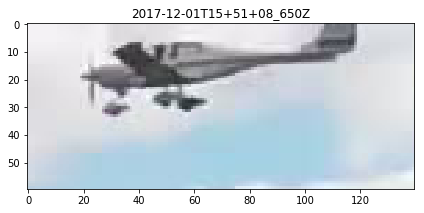

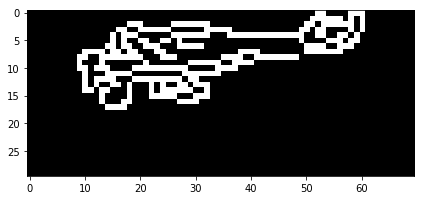

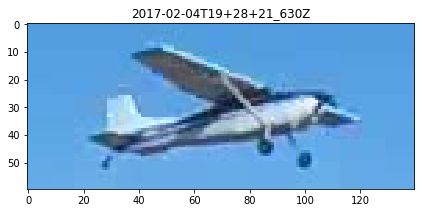

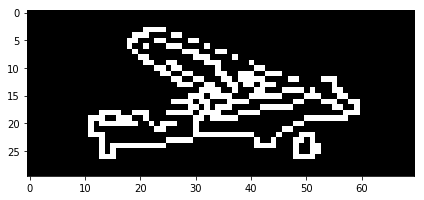

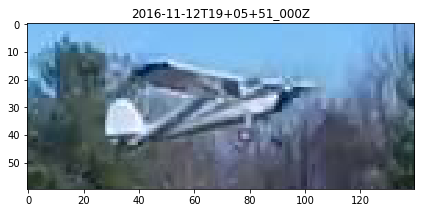

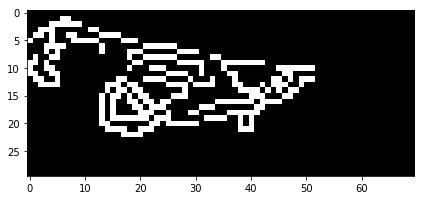

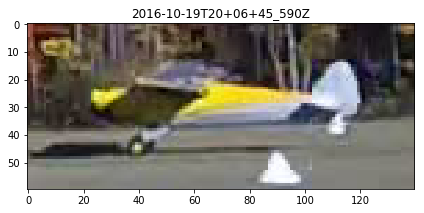

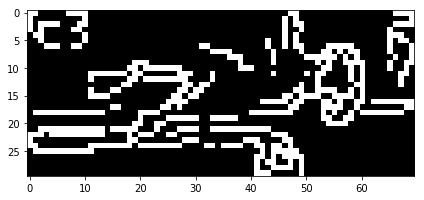

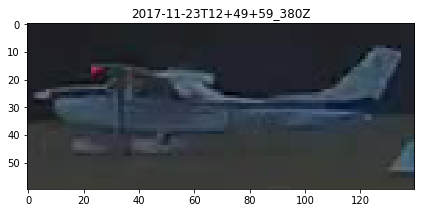

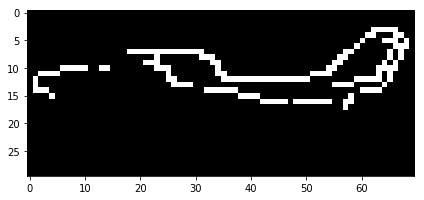

In [237]:
performance_examples('FN', nn_img_indices_to_view)

# comparisons

In [238]:
# list of fits to compare: 
final_fits = []
final_fits.append(prc_performance.performance_measures)
final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)

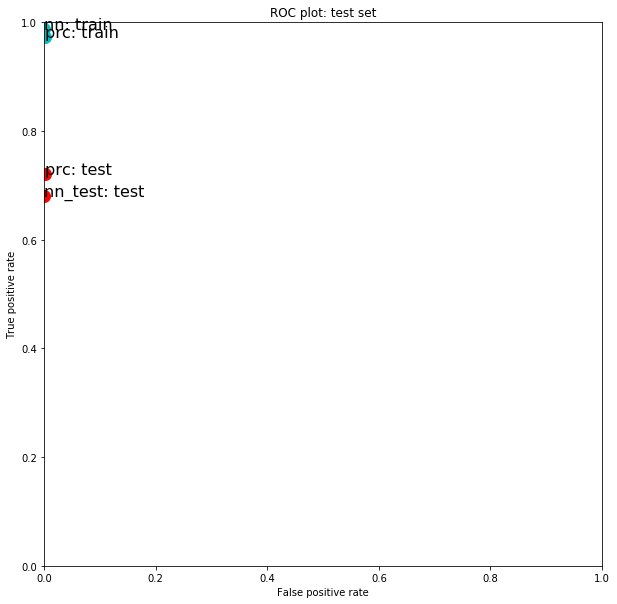

In [239]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
